## Titanic disaster exploration (Long Tutorial)

### Myself: Ranjit Kumar | Bioinformatics Scientist | rkumar@uab.edu

#### Note: Inspired by various tutorials on kaggle , online resources and my experience with Caret (R).
We are going to use the following analytical template that I have comeup with.
Step 1. Get data - Grab the training and test data in dataframe (columns as variables).
Step 2. Explore variables - Explore the data, data types, numerical, categorical, missing values etc
Step 3. Transform variables - Merge training and test data so as to perform data transformaion at same time
4. For all variables
  a. Explore the data , data type, missing values. Explore variables w.r.t labels like correlation analysis
  b. Clean, impute (add missing values or fill with fixed data)  and extract data if needed
  c. Encode the data into categorical variables.
  d. If continuos variable,  transform it into bands/label (based on some logical/graphical input)
  e. Look at the data dsitrubution for the need of normalisation/standardisation
5. Perform feature engineering if possible.
6. Drop useless variables
7. Transform all categories into numerical values using preprocessing module
8. Split Training and Test Sets
9. For each algorithm being tested
  a. Fine Tune Algorithms - Use grid search / random search to select best parameters (optional) and select best parameters and model
  b. Cross Validate with KFold - Using Kfold cross validation to identify average accuracy of the model
  c. Apply model on test dataset to acquire results
10. Try ensemble techniques like bagging , boosting or stacking to see if it improves the accuracy

**The steps 5, 9a, 10 are more toward improving the model which we will try once we build our first model.**

** Imp : Always look for data leakage, overfitting possibilities **

In [39]:
#!/bin/python

# Importing data-wrangling libraries
import pandas as pd
import numpy as np
import random as rnd

# Importing visualisation libraries
import seaborn as sns
import matplotlib.pyplot as plt
# this is only used for jupyter for inline display
%matplotlib inline

# Importing machine learning data processing libraries
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Importing machine learning modelling libraries

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler

# Importing machine learning parameter tuning libraries
from sklearn.model_selection import GridSearchCV

# Importing machine learning Kfold cross validation libraries
#from sklearn.cross_validation import KFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# library for my MAC for retina display
%config InlineBackend.figure_format = 'retina'

# for pretty display
from IPython.core.display import display, HTML



### Step 1: Grab the data

In [40]:
# Importing Titanic datasets
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Lets create a copy of original data (good idea for many reasons some might be unpredictable)
train = train_df.copy()
test = test_df.copy()

# Train will contain all categorical data which is further converted into categorical and numerical.
# train_std will contain standardized data.
# For Kfold cross validation we split train/train_std into X and Y dataset with their respective taining and test dataset.


### Step 2. Explore the data, data types, numerical, categorical, missing values

In [41]:
# Function for describing the dataframe

# Function to print a object but in a html converted format (useful for jupyter). we will use printx instead of print command. 
def printx(str):
    display(HTML(str.to_html()))

# Generic fucntion to describe any data frame named 'df'
def describe_df(df):
    # Display the column names, data type and entries
    print("\n-- df.info --\n")
    df.info()
    #print(df.columns.values)
    
    # Lets look at top 10 and last 10 entries
    print("\n-- df.head() --")
    printx(df.head())
    print("\n-- df.tail() --")
    printx(df.tail())
    
    # Describe both numerical and categorial variables
    print("\n-- Describe the numerical values : df.describe() --")
    printx(df.describe())
    print("\n--  Describe the categorical values : df.describe(include=['O']) --")
    printx(df.describe(include=['O']))

# Function to compare a list of columns with column corresponding label.
# Require 3 arguments, data frame, list, variable
#def compare_attr(df, column_list, label_var):
#    for attrib in column_list:
#        print("\n", '*' * 40)
#        printx(train_df[[attrib, label_var]].groupby([attrib]).mean().sort_values(by=label_var, ascending=False))
        



In [42]:
# Describe the training dataset
print("\n Describing training data \"train\" as df:")  
describe_df(train)

# If needed we can also look at test using similar function. Although its not required.
# describe_df(test)


 Describing training data "train" as df:

-- df.info --

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB

-- df.head() --


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S



-- df.tail() --


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q



-- Describe the numerical values : df.describe() --


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200



--  Describe the categorical values : df.describe(include=['O']) --


,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Gillespie, Mr. William Henry",male,1601,G6,S
freq,1,577,7,4,644


### Lets look at each variable at a time, notice data type, missing data and make some intutive guess. 
Learn about each variable at a time (https://www.kaggle.com/c/titanic/data)
- 12 variables (7 numeric and 5 categorical). Columns Age, Cabin, Embarked have missing values.
- Passenger ID : Doesn't seems like a predictor and can be dropped.
- Survived : This is our outcome variable (or label) and will be kept on another table/data frame. The outcome is binary in nature and hence it is a classification problem.
- Pclass : Its a Passenger/ticket class and can have 3 values as 1/2/3. Can be a predictor as different class might be located in different portions of ship which can correlated survival possibility. 
- Name : In general it might not be useful but in this case the data is formatted where Surname is provided. The surname may represent age/intellect and can be a informative variable. We will extract the Surname only and treat it as categorial variable. 
- Sex : It should be a good predictor as womens and kids were given preference in emergency situations. 
- Age : It should be a good predictor as young people and kids were given preference in emergency situations. However we see missing values here, so there is going to be some imputation (filling missing values).
- SibSp : It is # of siblings / spouses aboard the Titanic. Might have some correlation.
- Parch : It is # of parents / children aboard the Titanic. Might have some correlation.
- ticket : The ticket number does not seems to be a good predictor so we might drop it.

Feature engineering: I think SibSp and Parch information can be combined to generate a new fature "FamilyMembers" which might be more useful than these two alone.


##### Big picture patterns
  The percentage of people survived of total is 38 % as shown below. So any attribute or its categories that deviate from this percentage in either direction has possibility of good predictor. 


In [43]:
# Calculate the percentage of people survived of total is
(train.Survived.sum()) / (train.Survived.count()) * 100

38.383838383838381

Lets have a look at all the data in heatmap style to get a quick and dirty sense of good predictors. We will transform categorial cariables using get_dummy function of pandas. We wont use attributes here like Name, Ticket, Parch which has too many categories etc.

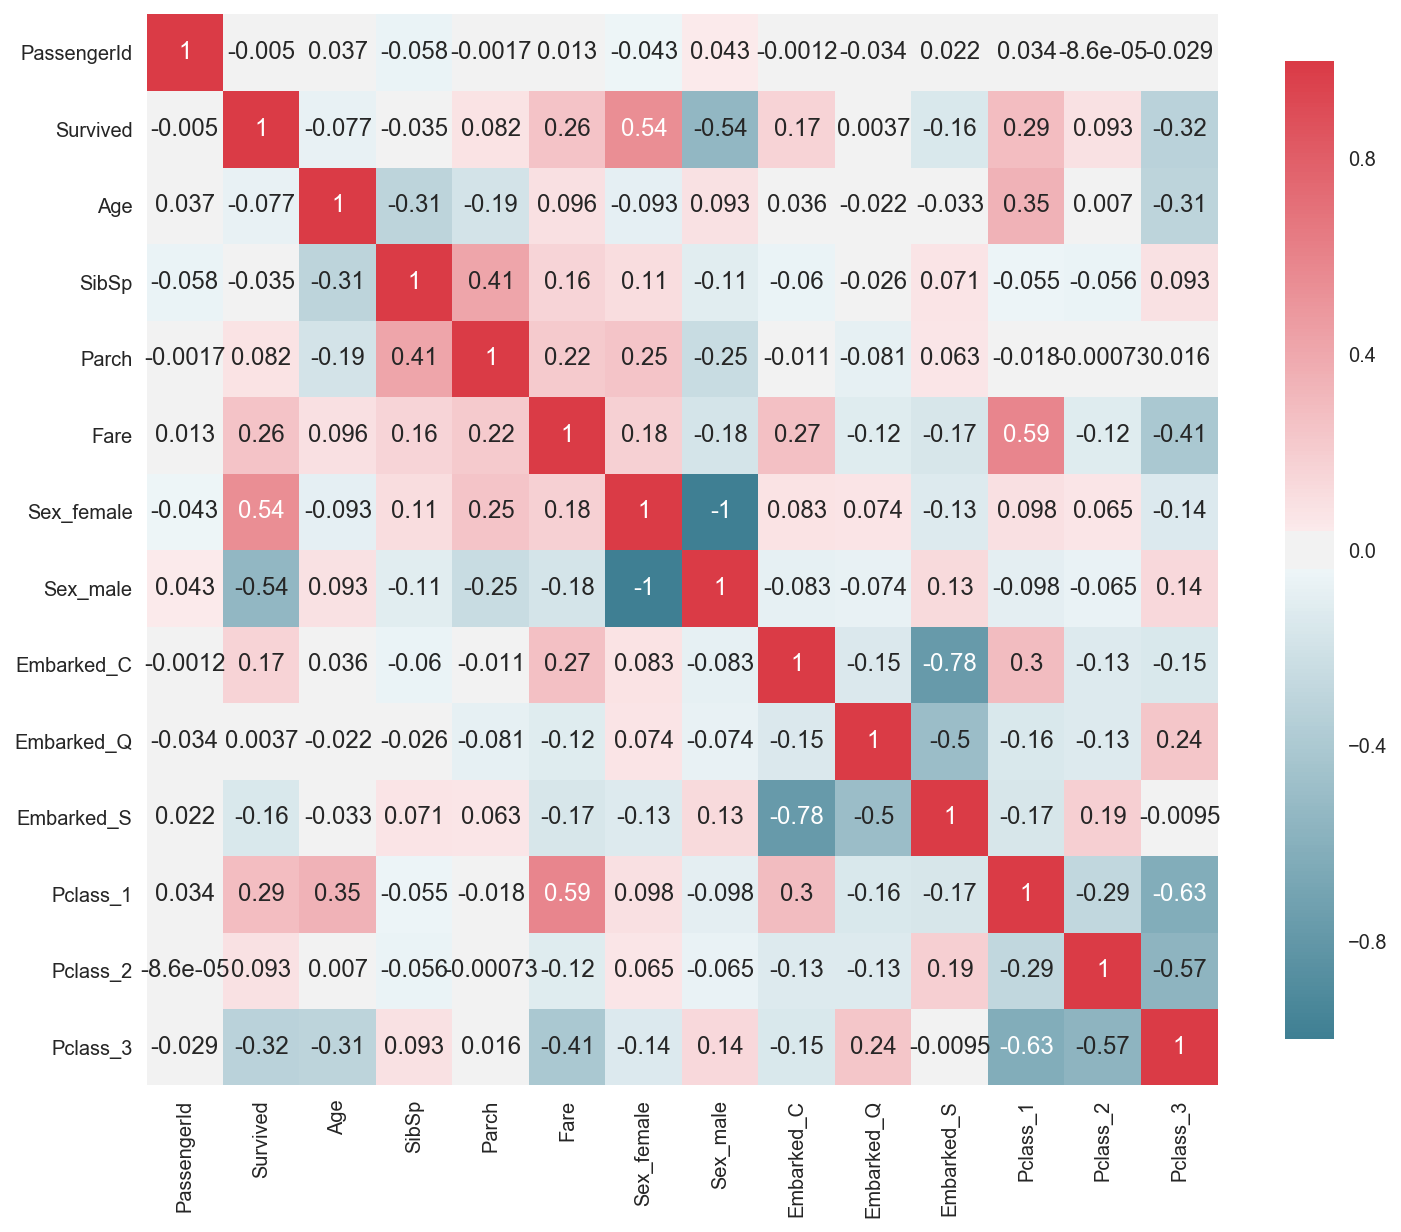

In [44]:
# lets have a heatmap look at various varaibles
cols_to_transform = [ 'Sex', 'Embarked','Pclass']
train_with_dummies = pd.get_dummies( train, columns = cols_to_transform )
corr = train_with_dummies.corr()
_ , ax = plt.subplots( figsize =( 12 , 10 ) )
cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
sns.heatmap(corr, cmap = cmap, square=True, cbar_kws={ 'shrink' : .9 }, ax=ax, annot = True, annot_kws = { 'fontsize' : 12 }
           )

#### Important points
- Positive predictors are - sex_female, Fare, Pclass_1. Negative are sex_male, Pclass_3, Embarked_S. Sex turns out to be a single most predictor.
- Its good to look other attributes with Sex distribution

Lets look at each attribute more closely and apply transformation (convert all data into categorical variables).

In [45]:
# Functions to apply data transformations for features for both train and test datset 
# the training and test are not merged and converted seperately using same principle
# This approach can prevent data leakage.

def describe_count_null(df,column):
    print ("Total data points available are ", df[column].count(), " and missing data points are", df[column].isnull().sum())

def transform_sex(train,test):
    train.Sex = train.Sex.fillna('NA')
    test.Sex = test.Sex.fillna('NA')
    return train,test
    
def transform_Pclass(train,test):
    train.Pclass = train.Pclass.fillna(-0.5)
    test.Pclass = test.Pclass.fillna(-0.5)
    return train,test

def transform_Age(train,test):
    # Add a new transformed column Age2
    train['Age2'] = train.Age
    test['Age2'] = test.Age
    train.Age2 = train.Age2.fillna(-0.5)
    test.Age2 = test.Age2.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    #group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    #categories = pd.cut(train_df.Age2, bins,labels=group_names))
    categories = pd.cut(train.Age2, bins)
    train.Age2 = categories
    categories = pd.cut(test.Age2, bins)
    test.Age2 = categories
    return train,test

def transform_Fmembers(train,test):
    # Not checking for NA in Parch & SibSp
    train['FamilyMembers'] = train['Parch'] + train['SibSp']
    test['FamilyMembers'] = test['Parch'] + test['SibSp']
    train.FamilyMembers = train.FamilyMembers.fillna(0)
    test.FamilyMembers = test.FamilyMembers.fillna(0)
    #bins = (-1, 0, 1000)
    #categories = pd.cut(train.FamilyMembers, bins)
    #train.FamilyMembers = categories
    #categories = pd.cut(test.FamilyMembers, bins)
    #test.FamilyMembers = categories    
    return train,test    


def transform_Fare(train,test):
    train['Fare2'] = train.Fare
    test['Fare2'] = test.Fare
    train.Fare2 = train.Fare.fillna(-0.5)
    test.Fare2 = test.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    #categories = pd.cut(train_df.Fare2, bins, labels=group_names)
    categories = pd.cut(train.Fare2, bins)
    train.Fare2 = categories
    categories = pd.cut(test.Fare2, bins)
    test.Fare2 = categories
    return train,test
    
def transform_Cabin(train,test):
    train['Cabin2'] = train.Cabin
    test['Cabin2'] = test.Cabin
    train.Cabin2 = train.Cabin2.fillna('N')
    test.Cabin2 = test.Cabin2.fillna('N')
    train.Cabin2 = train.Cabin2.apply(lambda x: x[0])
    test.Cabin2 = test.Cabin2.apply(lambda x: x[0])
    return train,test

def transform_Embarked(train,test):
    train.Embarked = train.Embarked.fillna('N')
    test.Embarked = test.Embarked.fillna('N')
    return train,test    
    
def transform_Name(train,test):
    # Add a new transformed column Title
    train.Name = train.Name.fillna('NA')
    test.Name = test.Name.fillna('NA')        
    train[ 'Title' ] = train['Name'].map( lambda x: x.split( ',' )[1].split( '.' )[0].strip() )
    test[ 'Title' ] = test['Name'].map( lambda x: x.split( ',' )[1].split( '.' )[0].strip() )

    print ("\n\nCategory counts before mapping\n")
    print(train.Title.value_counts(),"\n")
    
    # a map of more aggregated titles
    Title_Dictionary = {
                    "Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Jonkheer":   "Royalty",
                    "Don":        "Royalty",
                    "Sir" :       "Royalty",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "the Countess":"Royalty",
                    "Dona":       "Royalty",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Master" :    "Master",
                    "Lady" :      "Royalty",
                    "NA"   :    "NA"
                    }

    #train[ 'Title' ] = train.Title.map( Title_Dictionary )
    #test[ 'Title' ] = test.Title.map( Title_Dictionary )
    print ("\n\nCategory counts after mapping\n")
    print(train.Title.value_counts(),"\n")
    return train,test

#### Attribute : Sex
From figure below, it looks like a good predictor as females have very high survival chance for class 1 and 2. The proportion of males is twice more than females.

Total data points available are  891  and missing data points are 0

         Survived
Sex             
female       314
male         577


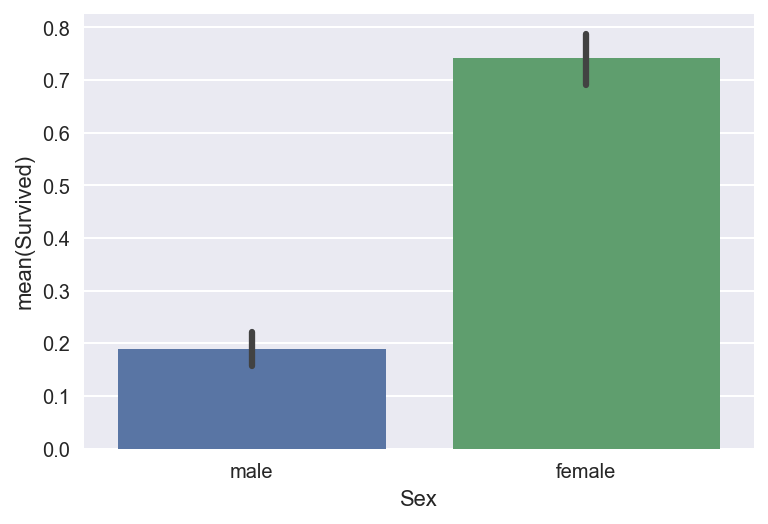

In [46]:
describe_count_null(train,'Sex')
train,test = transform_sex(train,test)
print("\n",train[["Sex", "Survived"]].groupby(['Sex']).count())
sns.barplot(x="Sex", y="Survived", data=train);


#### Attribute : Pclass
From figure below, it looks like a good predictor as females have very high survival chance for class 1 and 2.

Total data points available are  891  and missing data points are 0


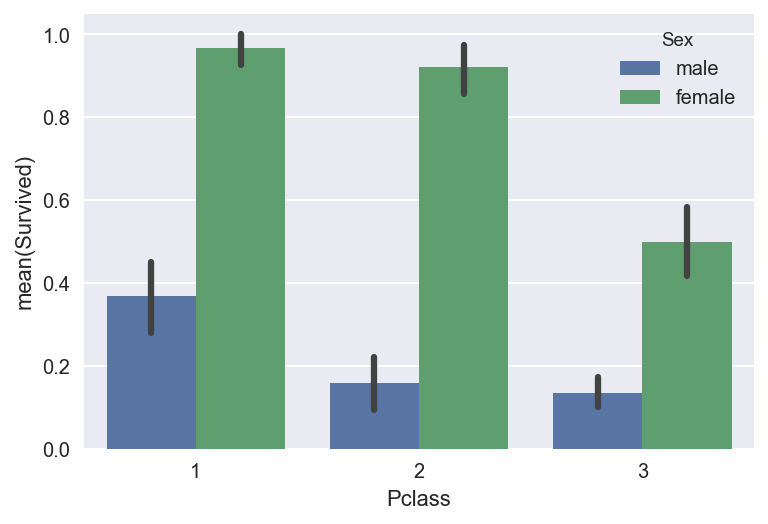

In [47]:
describe_count_null(train,'Pclass')
train,test = transform_Pclass(train,test)
sns.barplot(x="Pclass", y="Survived", hue="Sex", data=train);

#### Attribute : Name
Lets check if Name can act as useful predictor. We will extract Title (which emphasize age/experience etc) and see if it act as good predictor. It can be dropped later if it does not affect performance.

Total data points available are  891  and missing data points are 0


Category counts before mapping

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Major             2
Col               2
Mlle              2
Sir               1
the Countess      1
Ms                1
Jonkheer          1
Capt              1
Mme               1
Don               1
Lady              1
Name: Title, dtype: int64 



Category counts after mapping

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Major             2
Col               2
Mlle              2
Sir               1
the Countess      1
Ms                1
Jonkheer          1
Capt              1
Mme               1
Don               1
Lady              1
Name: Title, dtype: int64 



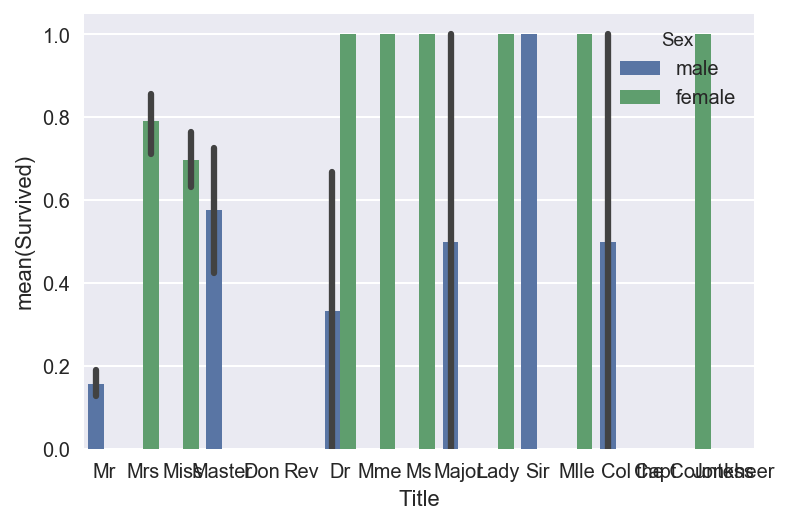

In [48]:
#Extract the middle name from Name column and get its value count
describe_count_null(train,'Name')
train,test = transform_Name(train,test)

sns.barplot(x="Title", y="Survived", hue="Sex", data=train);

#### Attribute : Age
From figure below, we see age has missing data points. We add missing values and categorise the data my experience toavoid ovefitting. However one can experiment with categories and impute the missing values based on other attributes(like KNN).

Total data points available are  714  and missing data points are 177


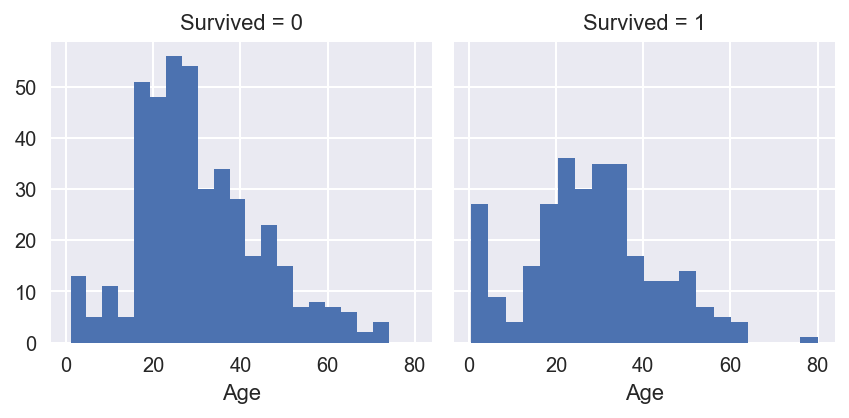

In [49]:
describe_count_null(train,'Age')

# Exploring age and plotting histogram
hist_age = sns.FacetGrid(train, col='Survived')
hist_age.map(plt.hist, 'Age', bins=20);
#sns.plt.show()


(25, 35]     196
(35, 60]     195
(-1, 0]      177
(18, 25]     162
(12, 18]      70
(0, 5]        44
(5, 12]       25
(60, 120]     22
Name: Age2, dtype: int64 



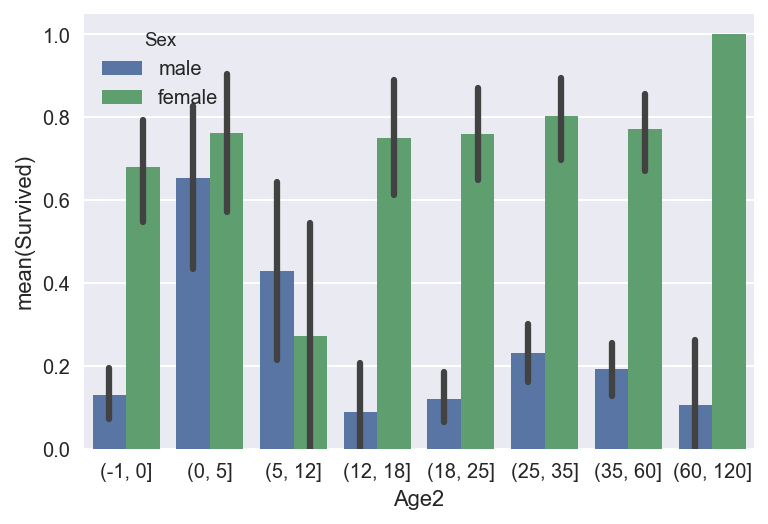

In [50]:
train,test = transform_Age(train,test)

print(train.Age2.value_counts(),"\n")
sns.barplot(x="Age2", y="Survived", hue="Sex", data=train);

#### Attribute : SibSp & Parch 
From figure below, it seems that combining faetures might be good idea

Total data points available are  891  and missing data points are 0


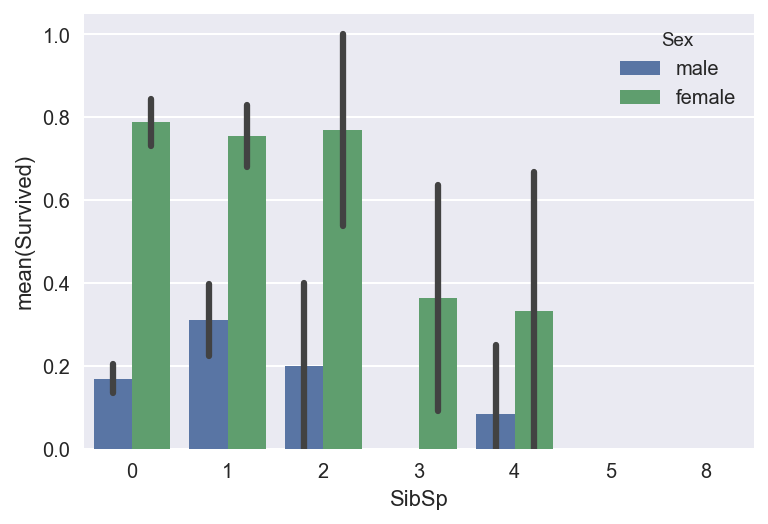

In [51]:
describe_count_null(train_df,'SibSp')
sns.barplot(x="SibSp", y="Survived", hue="Sex", data=train_df);

Total data points available are  891  and missing data points are 0


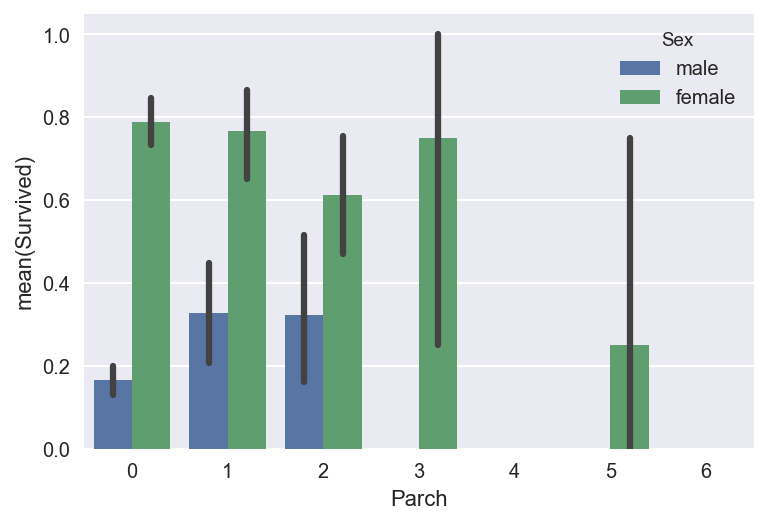

In [52]:
describe_count_null(train_df,'Parch')
sns.barplot(x="Parch", y="Survived", hue="Sex", data=train_df);

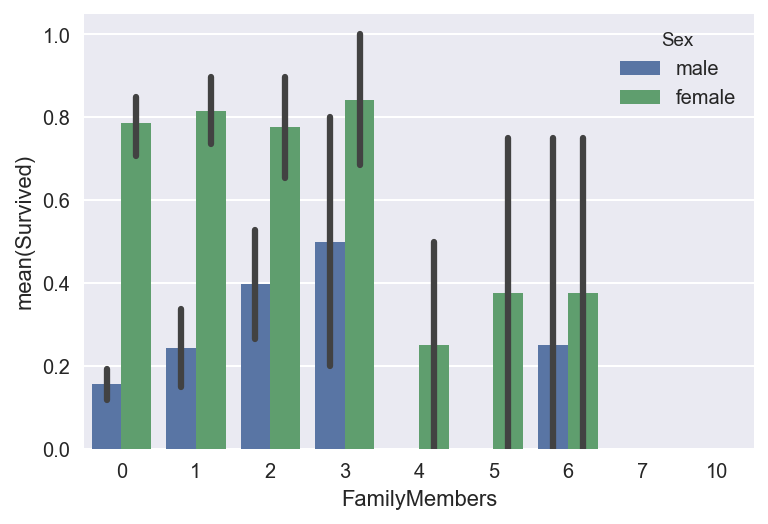

In [53]:
train,test = transform_Fmembers(train,test)
sns.barplot(x="FamilyMembers", y="Survived", hue="Sex", data=train);

**Very interesting: the survival of Male have increased as count of family members have increased.**

#### Attribute : Fare
From figure below, it seems that combining faetures might be good idea

Total data points available are  891  and missing data points are 0


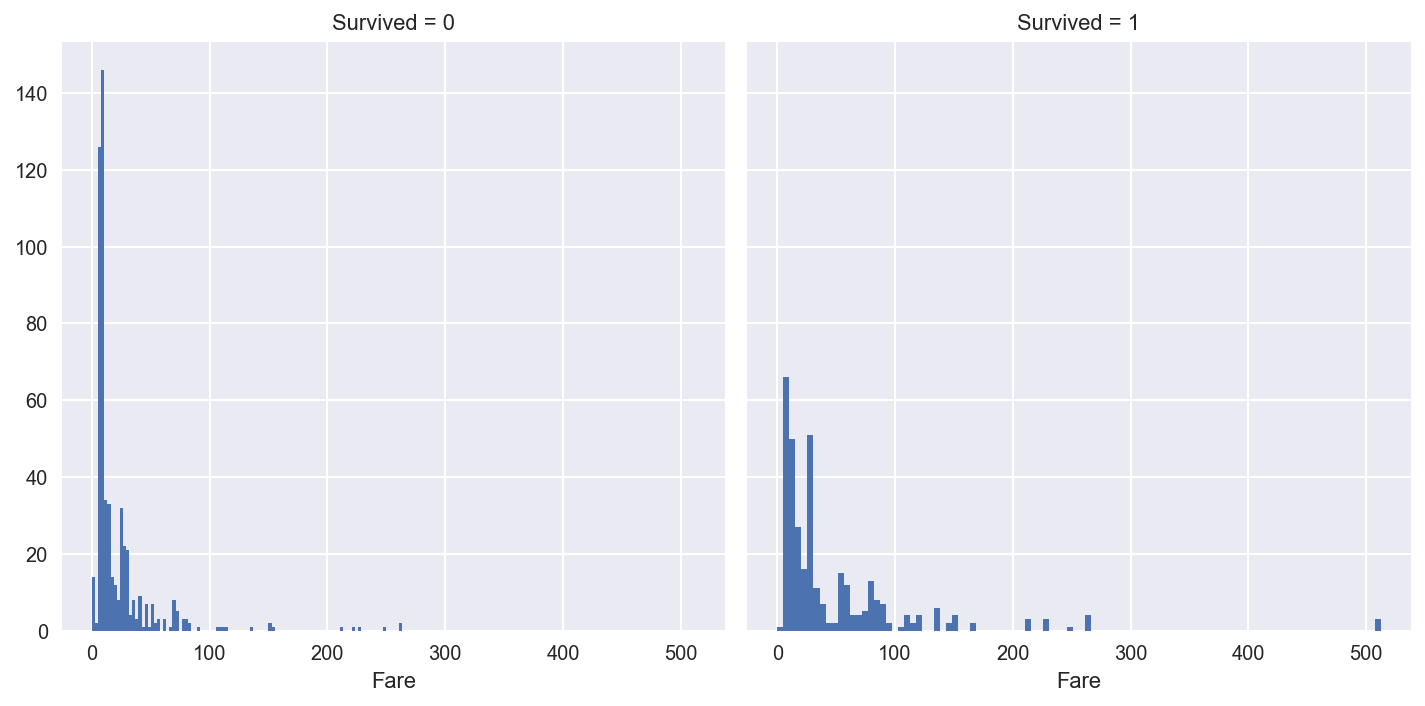

In [54]:
describe_count_null(train,'Fare')
hist_fare = sns.FacetGrid(train, col='Survived',size=5)
hist_fare.map(plt.hist, 'Fare', bins=100);

Total data points available are  891  and missing data points are 0
Total data points available are  417  and missing data points are 1
Total data points available are  891  and missing data points are 0
Total data points available are  418  and missing data points are 0
(0, 8]        226
(31, 1000]    222
(8, 15]       217
(15, 31]      211
(-1, 0]        15
Name: Fare2, dtype: int64 



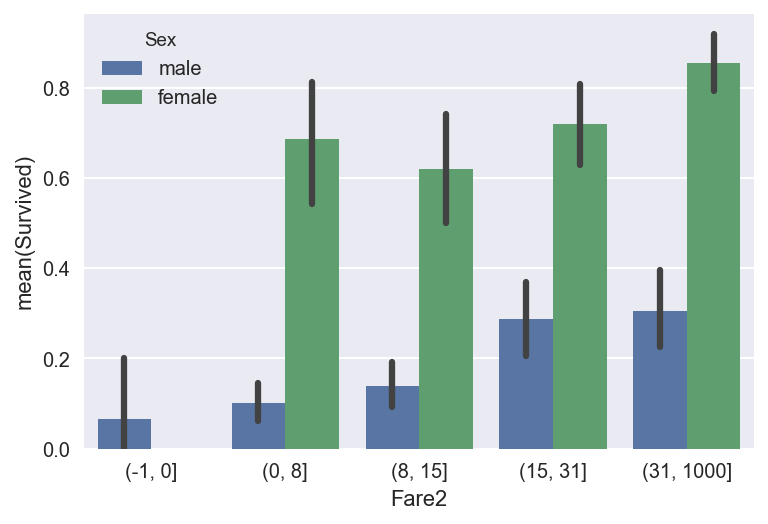

In [55]:
describe_count_null(train,'Fare')
describe_count_null(test,'Fare')
train,test = transform_Fare(train,test)
describe_count_null(train,'Fare2')
describe_count_null(test,'Fare2')

print(train.Fare2.value_counts(),"\n")
sns.barplot(x="Fare2", y="Survived", hue="Sex", data=train);

In [56]:
test.to_csv('x.csv', index = False)

** As fare increases the survival of male increases **

#### Attribute : Cabin
It has alot of missing data so we check if it looks useful, otherwise we will ignore it.

Total data points available are  204  and missing data points are 687
After categorisation

N    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin2, dtype: int64 



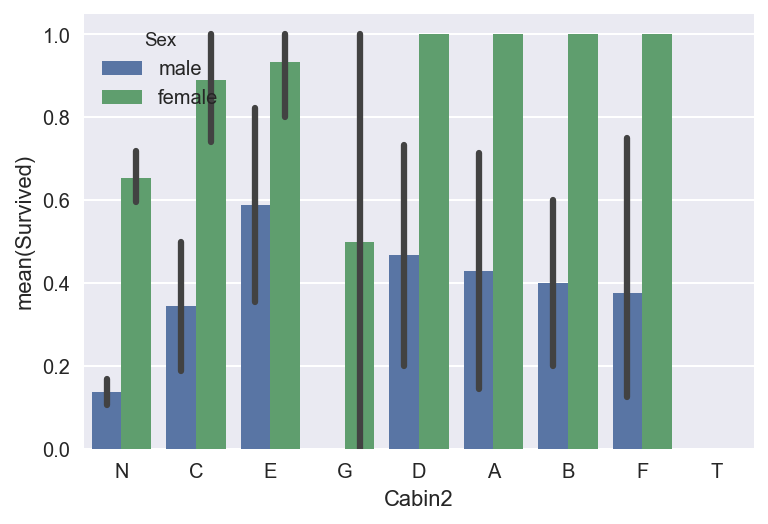

In [57]:
describe_count_null(train,'Cabin')
train,test = transform_Cabin(train,test)
sns.barplot(x="Cabin2", y="Survived", hue="Sex", data=train);
print("After categorisation\n")
print(train.Cabin2.value_counts(),"\n")



** The fare distrubution seems predictive **

#### Attribute : Embarked


Total data points available are  889  and missing data points are 2



S    644
C    168
Q     77
N      2
Name: Embarked, dtype: int64 



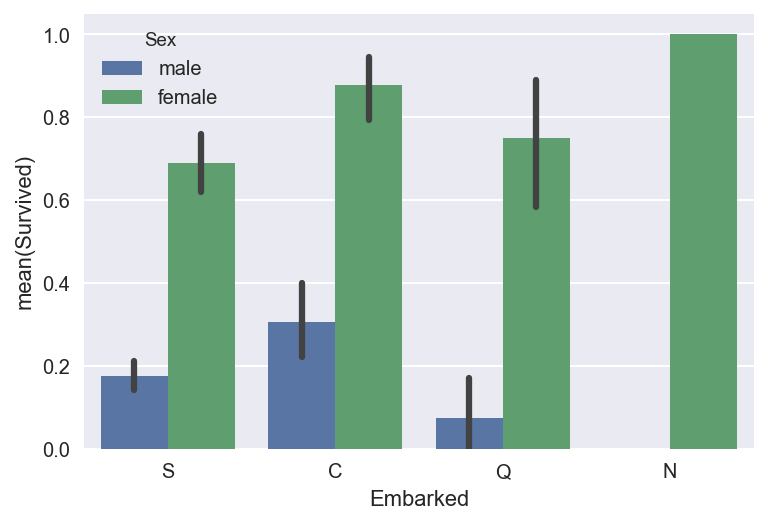

In [58]:
describe_count_null(train,'Embarked')
train,test = transform_Embarked(train,test)
print("\n\n")
print(train.Embarked.value_counts(),"\n")

sns.barplot(x="Embarked", y="Survived", hue="Sex", data=train);

#### Drop extra features

In [59]:
# Here is the list of all the columns
print(train.columns)
print(test.columns)


Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title', 'Age2',
       'FamilyMembers', 'Fare2', 'Cabin2'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title', 'Age2', 'FamilyMembers',
       'Fare2', 'Cabin2'],
      dtype='object')


In [60]:
# Drop columns not deemed as useful
drop_columns = ['PassengerId', 'Name', 'Age', 'FamilyMembers', 'Ticket', 'Fare','Cabin']
#drop_columns = ['PassengerId', 'Name', 'Age', 'SibSp','Parch', 'Ticket', 'Fare', 'Cabin','FamilyMembers','Cabin2','Fare2']

train_slim = train.drop(drop_columns, axis=1)
test_slim = test.drop(drop_columns, axis=1)
printx(train_slim.head())
print ("---")
printx(test_slim.head())
test_slim.to_csv('test_slim.csv', index = False)
train_slim.to_csv('train_slim.csv', index = False)


,Survived,Pclass,Sex,SibSp,Parch,Embarked,Title,Age2,Fare2,Cabin2
0,0,3,male,1,0,S,Mr,"(18, 25]","(0, 8]",N
1,1,1,female,1,0,C,Mrs,"(35, 60]","(31, 1000]",C
2,1,3,female,0,0,S,Miss,"(25, 35]","(0, 8]",N
3,1,1,female,1,0,S,Mrs,"(25, 35]","(31, 1000]",C
4,0,3,male,0,0,S,Mr,"(25, 35]","(8, 15]",N


---


,Pclass,Sex,SibSp,Parch,Embarked,Title,Age2,Fare2,Cabin2
0,3,male,0,0,Q,Mr,"(25, 35]","(0, 8]",N
1,3,female,1,0,S,Mrs,"(35, 60]","(0, 8]",N
2,2,male,0,0,Q,Mr,"(60, 120]","(8, 15]",N
3,3,male,0,0,S,Mr,"(25, 35]","(8, 15]",N
4,3,female,1,1,S,Mrs,"(18, 25]","(8, 15]",N


In [61]:
# Lets define some more functions to Encode label, Normalisation, 

def label_encoder(train,test,train_test):
    for feature in train.columns:
        #print(feature)
        le = preprocessing.LabelEncoder()
        le = le.fit(train_test[feature])
        train[feature] = le.transform(train[feature])
        test[feature] = le.transform(test[feature])
        
    train = pd.DataFrame(train, columns = train.columns)
    test = pd.DataFrame(test, columns = test.columns)
    return train,test

# Normalisation and standardisation
# Normalization is mainly necessary in case of algorithms which use distance measures 
# like clustering,recommender systems which use cosine similarity etc.

def data_standardisation(train,test):
    #std_scale = preprocessing.StandardScaler().fit(train)
    std_scale = preprocessing.RobustScaler().fit(train)
    train_std = std_scale.transform(train)
    test_std = std_scale.transform(test)
    return train_std,test_std


In [62]:

# Lets drop the label from the training data
X_all = train_slim.drop(['Survived'], axis=1)
Y_all = train_slim['Survived']

# create a merge dataset for label Encoder
train_test = X_all.append(test_slim)

# Encode variables
X_all,test_slim = label_encoder(X_all,test_slim,train_test)

# Standardize data
X_all_std,test_slim_std = data_standardisation(X_all,test_slim)


In [63]:
# Create a list of models and run the prediction through all models in Kfold cross validation
def evaluate_models(train,test,split_num=5,random_num=7):
    models = []
    models.append(('LR', LogisticRegression()))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('KNN', KNeighborsClassifier(n_neighbors = 3)))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('RF', RandomForestClassifier()))
    models.append(('NB', GaussianNB()))
    models.append(('SVM', SVC()))
    models.append(('GBC',GradientBoostingClassifier()))
    models.append(('ABC',AdaBoostClassifier()))
    #print(models)

    # evaluate each model in turn
    results = []
    names = []
    scoring = 'accuracy'
    for name, model in models:
        kfold = KFold(n_splits=split_num, random_state=random_num)
        cv_results = cross_val_score(model,train, test, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
def ensembl_voting(train,test,split_num=5,random_num=7):       
    # Lets Check the voting algorithm
    models = []
    models.append(('LR', LogisticRegression()))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('RF', RandomForestClassifier()))
    models.append(('NB', GaussianNB()))
    models.append(('SVM', SVC()))

    kfold = KFold(n_splits=10, random_state=7)
    ensemble = VotingClassifier(models)
    results = cross_val_score(ensemble, train, test, cv=kfold)
    print(results.mean())


In [64]:
# Lets do the prediction

print("\nBefore standardisation")
evaluate_models(X_all,Y_all,split_num=5,random_num=7)

print("\nAfter standardisation")
evaluate_models(X_all_std,Y_all,split_num=5,random_num=7)



Before standardisation
LR: 0.784514 (0.023431)
LDA: 0.786755 (0.014220)
KNN: 0.792380 (0.011559)
CART: 0.802486 (0.019727)
RF: 0.812586 (0.016319)
NB: 0.765438 (0.019505)
SVM: 0.808091 (0.023042)
GBC: 0.829421 (0.029756)
ABC: 0.819315 (0.027539)

After standardisation
LR: 0.786743 (0.015657)
LDA: 0.786755 (0.014220)
KNN: 0.801394 (0.025572)
CART: 0.800251 (0.022650)
RF: 0.810351 (0.030050)
NB: 0.765438 (0.019505)
SVM: 0.805863 (0.021218)
GBC: 0.830544 (0.027954)
ABC: 0.820438 (0.025778)


### Results
- As we can see most classifier are predicting accuracy between 75-83.
- Gradient bosted tree shows the rest 83% whereas random forest are showing around 80.5%



In [65]:
# Final prediction using gradient boosting classifier
#random_forest = RandomForestClassifier()
GBC = GradientBoostingClassifier()
GBC.fit(X_all_std, Y_all)
test_pred = GBC.predict(test_slim_std)
output = pd.DataFrame({ 'PassengerId' : test_df.PassengerId, 'Survived': test_pred })
output.head()
output.to_csv('titanic-predictions_basic2.csv', index = False)

output = pd.DataFrame({ 'Column' : X_all.columns, 'Score': GBC.feature_importances_ })
print("\nFeature importance using GBC is \n",output)




Feature importance using GBC is 
      Column     Score
0    Pclass  0.069055
1       Sex  0.137427
2     SibSp  0.150824
3     Parch  0.053496
4  Embarked  0.036309
5     Title  0.138847
6      Age2  0.195111
7     Fare2  0.081573
8    Cabin2  0.137357


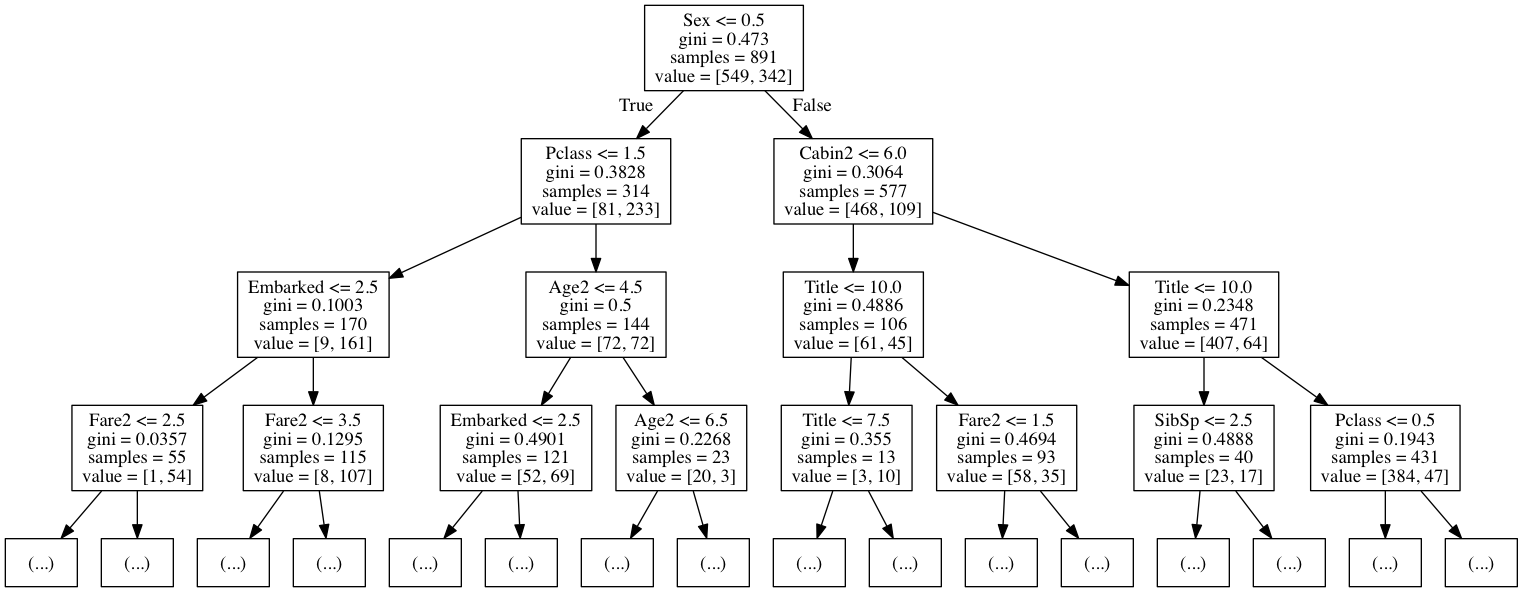

In [66]:
# quick look at decision tree at depth 3
# The tree graph will make moire sense when given categorical variables.
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_all, Y_all)


import pydotplus as pydot

from IPython.display import Image

from sklearn.externals.six import StringIO
from sklearn import tree

dot_data = StringIO()

tree.export_graphviz(decision_tree, out_file=dot_data,max_depth=3,feature_names=X_all.columns)

graph = pydot.graph_from_dot_data(dot_data.getvalue())

Image(graph.create_png())

In [67]:
# Extra looking for feature importance

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier

def explore_feature_imp(train,label):
    test = SelectKBest(score_func=chi2, k=4)
    fit = test.fit(train,label)
    output = pd.DataFrame({ 'Column' : train.columns, 'Score': fit.scores_ })
    print("\nScoring using Chi squre function is \n",output)
    
    model = LogisticRegression()
    rfe = RFE(model, 3)
    fit = rfe.fit(train,label)
    output = pd.DataFrame({ 'Column' : train.columns, 'Score': fit.ranking_ })
    print("\nScoring using Recursive feature elimination (regression) is \n",output)

    model = ExtraTreesClassifier()
    model.fit(train, label)
    output = pd.DataFrame({ 'Column' : train.columns, 'Score': model.feature_importances_ })
    print("\nScoring using Extra tree classifier is \n",output)

explore_feature_imp(X_all +10,Y_all)


Scoring using Chi squre function is 
      Column      Score
0    Pclass   6.302819
1       Sex   5.638169
2     SibSp   0.059676
3     Parch   0.371151
4  Embarked   3.008040
5     Title   5.230166
6      Age2   0.081380
7     Fare2   0.822986
8    Cabin2  20.674496

Scoring using Recursive feature elimination (regression) is 
      Column  Score
0    Pclass      3
1       Sex      1
2     SibSp      7
3     Parch      1
4  Embarked      5
5     Title      6
6      Age2      4
7     Fare2      1
8    Cabin2      2

Scoring using Extra tree classifier is 
      Column     Score
0    Pclass  0.119995
1       Sex  0.298308
2     SibSp  0.065109
3     Parch  0.048393
4  Embarked  0.047630
5     Title  0.106091
6      Age2  0.124141
7     Fare2  0.084362
8    Cabin2  0.105971


#### More analysis
This is the staring point of the analysis. From here the experimentation starts
- Look at data more closely. It seems that sex variable itself can be 75% accurate classifier. Find while males lived and which females died for more pattern.
- Do more feature engineering.
- Impute missing data (learning from other rows) like age from other datasets.
- Ignore useless features
- Check if Ticket id contain imp information
- Perform hyper parameter tuning of algorithms.